In [1]:
import os
import torch
import numpy as np
import tqdm
import imageio
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from skimage import img_as_ubyte
from utils import image_grid
# io utils
from pytorch3d.io import load_obj

# datastructures
from pytorch3d.structures import Meshes, Textures

# 3D transformations functions
from pytorch3d.transforms import Rotate, Translate

# rendering components
from pytorch3d.renderer import (
    OpenGLPerspectiveCameras, look_at_view_transform, look_at_rotation, 
    RasterizationSettings, MeshRenderer, MeshRasterizer, BlendParams,
    SilhouetteShader, PhongShader, PointLights
)

In [2]:
# Set the cuda device 
device = torch.device("cuda:0")
torch.cuda.set_device(device)

# Load the obj and ignore the textures and materials.
verts, faces_idx, _ = load_obj("/home/hyosung/ImageDataset/PoseDataset/lm_full/models_obj/obj_000009.obj")
# verts, faces_idx, _ = load_obj("/home/hyosung/ImageDataset/PoseDataset/lm_full/models_obj/teapot.obj")
faces = faces_idx.verts_idx

# vertices align to center
verts[:,0] -= verts[:,0].mean()
verts[:,1] -= verts[:,1].mean()
verts[:,2] -= verts[:,2].mean()
# Initialize each vertex to be white in color.
verts_rgb = torch.ones_like(verts)[None]  # (1, V, 3)
textures = Textures(verts_rgb=verts_rgb.to(device))

# Create a Meshes object for the teapot. Here we have only one mesh in the batch.
model_mesh = Meshes(
    verts=[verts.to(device)],   
    faces=[faces.to(device)], 
    textures=textures
)

In [3]:
# Initialize an OpenGL perspective camera.
cameras = OpenGLPerspectiveCameras(device=device)

# To blend the 100 faces we set a few parameters which control the opacity and the sharpness of 
# edges. Refer to blending.py for more details. 
blend_params = BlendParams(sigma=1e-4, gamma=1e-4)

# Define the settings for rasterization and shading. Here we set the output image to be of size
# 256x256. To form the blended image we use 100 faces for each pixel. Refer to rasterize_meshes.py
# for an explanation of this parameter. 
raster_settings = RasterizationSettings(
    image_size=256, 
    blur_radius=np.log(1. / 1e-4 - 1.) * blend_params.sigma, 
    faces_per_pixel=100, 
    bin_size=0
)

# Create a silhouette mesh renderer by composing a rasterizer and a shader. 
silhouette_renderer = MeshRenderer(
    rasterizer=MeshRasterizer(
        cameras=cameras, 
        raster_settings=raster_settings
    ),
    shader=SilhouetteShader(blend_params=blend_params)
)

azimuth: tensor([-45.,  45.])


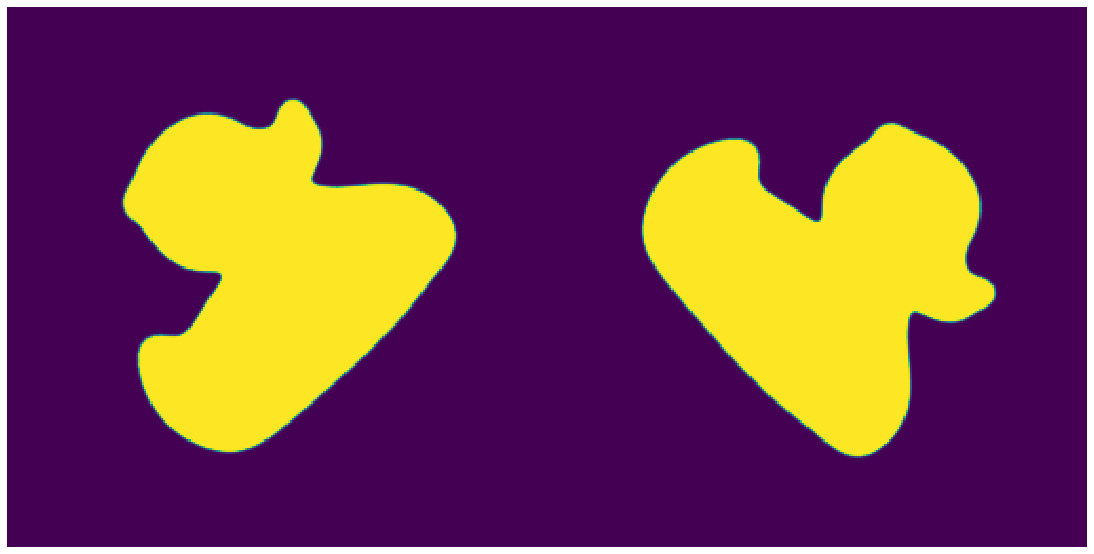

In [114]:
# Select the viewpoint using spherical angles  
batch_size = 2
distance = torch.tensor(150)   # distance from camera to the object
# elevation = torch.linspace(89.0, 89.0, batch_size)   # angle of elevation in degrees
elevation = torch.tensor([89.0, 89.0])
# azimuth = torch.linspace(0.0, 89.9, batch_size)  # angle of azimuth rotation in degrees
azimuth = torch.tensor([-45.0, 45.0])
ups = [(0, 1, 0),]*batch_size
# for i in range(batch_size):
#     if elevation[i] > 90.0:
#         ups[i] = (0, 0, 1)
print(f'azimuth: {azimuth}')
# Get the position of the camera based on the spherical angles
R, T = look_at_view_transform(distance, elevation, azimuth, up=ups, device=device)

# Render the teapot providing the values of R and T. 
image_ref = silhouette_renderer(meshes_world=model_mesh.extend(batch_size), R=R, T=T)
# image_ref = phong_renderer(meshes_world=model_mesh.extend(batch_size), R=R, T=T)

image_grid(image_ref.cpu().numpy(), rows=1, cols=2, rgb=False)

In [115]:
class Model(nn.Module):
    def __init__(self, meshes, renderer, image_ref):
        super().__init__()
        self.batch_size = len(image_ref)
        self.meshes = meshes.extend(batch_size)
        self.device = meshes.device
        self.renderer = renderer
        
        # Get the silhouette of the reference RGB image by finding all the non zero values. 
#         self.image_ref = torch.from_numpy((image_ref[..., :3].max(-1) != 0).astype(np.float32))
        self.image_ref = image_ref[..., 3]
#         self.register_buffer('image_ref', image_ref)
        
        # Select the viewpoint using spherical angles  
        self.distance = nn.Parameter(torch.tensor(150.))   # distance from camera to the object
        self.elevation = nn.Parameter(torch.tensor([89.0]*self.batch_size))   # angle of elevation in degrees
#         self.elevation = torch.tensor([89.0]*self.batch_size)   # angle of elevation in degrees
        self.azimuth = nn.Parameter(torch.tensor([0.0]*self.batch_size))      # angle of azimuth rotation in degrees       

    def forward(self):        
        # Get the position of the camera based on the spherical angles
        ups = [(0, 1, 0),]*self.batch_size
        for i in range(self.batch_size):
            if elevation[i] > 90.0:
                ups[i] = (0, 0, 1)
        R, T = look_at_view_transform(self.distance, self.elevation, self.azimuth, up=ups, device=self.device)
        image = self.renderer(meshes_world=self.meshes.clone(), R=R, T=T)
#         image = (image>0).float()
        # Calculate the silhouette loss
        loss = torch.sum((image[..., 3] - self.image_ref) ** 2) # input: sihouette, target: phong
        return loss, image, R, T

In [116]:
# We will save images periodically and compose them into a GIF.
filename_output = "./obj_optimization_demo.gif"
writer = imageio.get_writer(filename_output, mode='I', duration=0.3)

# silhouete = silhouette_renderer(meshes_world=model_mesh, R=R, T=T)

# Initialize a model using the renderer, mesh and reference image
model = Model(meshes=model_mesh, renderer=silhouette_renderer, image_ref=image_ref).to(device)


# Create an optimizer. Here we are using Adam and we pass in the parameters of the model
optimizer = torch.optim.Adam(model.parameters(), lr=0.5)

In [117]:
import time
tic = time.time()
loop = tqdm.notebook.tqdm(range(100))
for i in loop:
    optimizer.zero_grad()
    loss, _, R, T = model()
    loss.backward()
    optimizer.step()
    
    loop.set_description('Optimizing (loss %.4f)' % loss.data)
    
    if loss.item() < 200:
        break
    
    # Save outputs to create a GIF. 
    if i % 10 == 0:        
        
        image = silhouette_renderer(meshes_world=model.meshes.clone(), R=R, T=T)
        image = image.detach().squeeze().cpu().numpy()
        image = img_as_ubyte(image)
        image_stack = np.hstack((image[0,...,3], image[1,...,3]))
        writer.append_data(image_stack)
        
#         plt.figure()
#         plt.subplot(1,2,1)
#         plt.imshow(image[0, ..., 3])
#         plt.subplot(1,2,2)
#         plt.imshow(image[1, ..., 3])
#         plt.title("iter: %d, loss: %0.2f" % (i, loss.data))
#         plt.grid("off")
#         plt.axis("off")
    
writer.close()
elapsed_time = time.time() - tic
print(f'elabsed time: {elapsed_time}')

R is not a valid rotation matrix
R is not a valid rotation matrix

elabsed time: 8.488210678100586


In [49]:
print(R.detach().cpu().numpy())
print(T.detach().cpu().numpy())

[[[ 0.8839453   0.16474484 -0.43760702]
  [-0.          0.9358769   0.35232726]
  [ 0.4675904  -0.31143802  0.82726395]]

 [[ 0.95851755  0.01281379 -0.28474554]
  [-0.          0.998989    0.04495534]
  [ 0.2850337  -0.04309048  0.9575485 ]]]
[[-0.0000000e+00 -0.0000000e+00  1.5230658e+02]
 [ 3.8146973e-06 -4.7683716e-07  1.5230658e+02]]
